# Анализ эффективности удержания

В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

- state — штат США
- account_length — длительность использования аккаунта
- area_code — деление пользователей на псевдорегионы, использующееся в телекоме
- intl_plan — подключена ли у пользователя услуга международного общения
- vmail_plan — подключена ли у пользователя услуга голосовых сообщений
- vmail_message — количество голосых сообщений, который пользователь отправил / принял
- day_calls — сколько пользователь совершил дневных звонков
- day_mins — сколько пользователь проговорил минут в течение дня
- day_charge — сколько пользователь заплатил за свою дневную активность
- eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
- night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
- intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
- custserv_calls — сколько раз пользователь позвонил в службу поддержки
- treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
- mes_estim — оценка интенсивности пользования интернет мессенджерами
- churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('churn_analysis.csv', index_col=0)
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [ ]:
control_data = data[data.treatment == 1]
control_data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
8,LA,117,408,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,1,0.50,False.
12,IA,168,408,no,no,0,128.8,96,21.90,104.9,71,8.92,141.1,128,6.35,11.2,2,3.02,1,1,0.37,False.
17,VT,93,510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,1,0.84,False.


**Задание 1.**  

Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.  
Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn.
Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара.

Сколько достигаемых уровней значимости оказались меньше, чем $\alpha=0.05$?

In [ ]:
all_states = pd.crosstab(control_data.state, control_data.churn)

In [ ]:
states_pairs = list(itertools.combinations(all_states.index, 2))
len(states_pairs)

1275

In [ ]:
chi2_p = []
for pair in states_pairs:
    temp = control_data.query('state == @pair[0] | state == @pair[1]')
    subtable = pd.crosstab(temp.state, temp.churn)
    chi2_p.append(stats.chi2_contingency(subtable, correction=False)[1])

In [ ]:
print(f'Number of significant pairs with chi-squared test: {(np.array(chi2_p) < 0.05).sum()}')

Number of significant pairs with chi-squared test: 34


**Задание 3.**  

В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного $O_i$ и ожидаемого $E_i$ значений, то есть, статистика с такой поправкой выглядит так: $$\chi _{\text{Yates}}^{2}=\sum _{i=1}^{N}{(|O_{i}-E_{i}|-0.5)^{2} \over E_{i}}$$

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики $\chi^{2}$, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией 

In [ ]:
chi2_p_yates = []
for pair in states_pairs:
    temp = control_data.query('state == @pair[0] | state == @pair[1]')
    subtable = pd.crosstab(temp.state, temp.churn)
    chi2_p_yates.append(stats.chi2_contingency(subtable, correction=True)[1])

In [ ]:
print(f'Number of significant pairs with chi-squared test + Yates: {(np.array(chi2_p_yates) < 0.05).sum()}')

Number of significant pairs with chi-squared test + Yates: 0


In [ ]:
(np.array(chi2_p_yates) >= np.array(chi2_p)).all()

False

In [ ]:
np.array(chi2_p_yates).mean() > np.array(chi2_p).mean()

True

Видим, что поправка Йетса повышает p-value настолько, что не остаётся ни одного значимого результата. По отдельности не все уровни значимости оказались выше либо равными тех, что без поправки, но в среднем они больше.

**Задание 4.**  

Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

In [ ]:
fisher_p = []
for pair in states_pairs:
    temp = control_data.query('state == @pair[0] | state == @pair[1]')
    subtable = pd.crosstab(temp.state, temp.churn)
    fisher_p.append(stats.fisher_exact(subtable)[1])

In [ ]:
print(f'Number of significant pairs with Fisher exact test: {(np.array(fisher_p) < 0.05).sum()}')

Number of significant pairs with Fisher exact test: 10


In [ ]:
np.array(fisher_p).mean() < np.array(chi2_p).mean()

False

In [ ]:
np.array(fisher_p).mean() > np.array(chi2_p_yates).mean()

False

In [ ]:
np.array(fisher_p).mean() > np.array(chi2_p).mean(), np.array(fisher_p).mean() - np.array(chi2_p).mean()

(True, 0.1465109261281523)

In [ ]:
np.array(fisher_p).mean() < np.array(chi2_p_yates).mean()

True

**Задание 5.**  

Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость. 

In [ ]:
dcme_data = data[['day_calls', 'mes_estim']]
dcme_data.head()

,day_calls,mes_estim
0,110,0.65
1,123,0.55
2,114,0.72
3,71,0.28
4,113,0.45


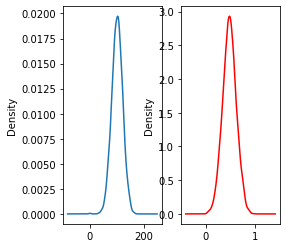

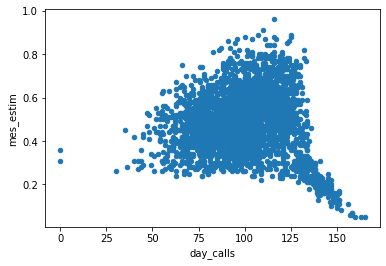

In [ ]:
plt.subplot(1, 3, 1)
dcme_data.day_calls.plot(kind='kde')
plt.subplot(1, 3, 2)
dcme_data.mes_estim.plot(kind='kde', color='r')
dcme_data.plot(x='day_calls', y='mes_estim', kind='scatter');

In [ ]:
coef, p = stats.pearsonr(dcme_data.day_calls, dcme_data.mes_estim)
print(f'Pearson correlation coefficient = {round(coef, 4)} with p-value = {round(p, 4)}')

Pearson correlation coefficient = -0.0518 with p-value = 0.0028


**Задание 6.**  

Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [ ]:
coef, p = stats.spearmanr(dcme_data.day_calls, dcme_data.mes_estim)
print(f'Spearman correlation coefficient = {round(coef, 4)} with p-value = {round(p, 4)}')

Spearman correlation coefficient = 0.0433 with p-value = 0.0123


**Задание 7.**

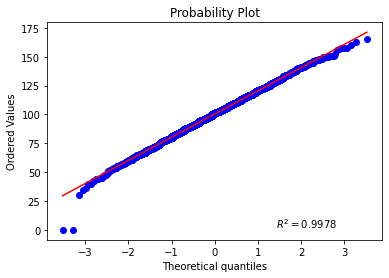

In [ ]:
stats.probplot(dcme_data.day_calls, plot=plt, rvalue=True);

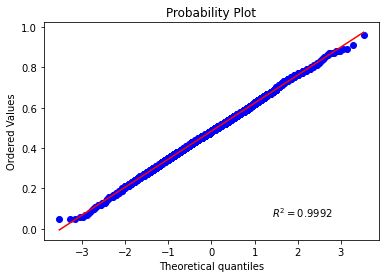

In [ ]:
stats.probplot(dcme_data.mes_estim, plot=plt, rvalue=True);

**Задание 8.**  

Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [ ]:
stats.chi2_contingency(all_states)[1]

0.7097590042778473

**Задание 9.**

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

In [ ]:
treat0_data = data[data.treatment == 0]
treat2_data = data[data.treatment == 2]

In [ ]:
treat0_churn = treat0_data.churn.map({'False.': 0, 'True.': 1})
treat1_churn = control_data.churn.map({'False.': 0, 'True.': 1})
treat2_churn = treat2_data.churn.map({'False.': 0, 'True.': 1})

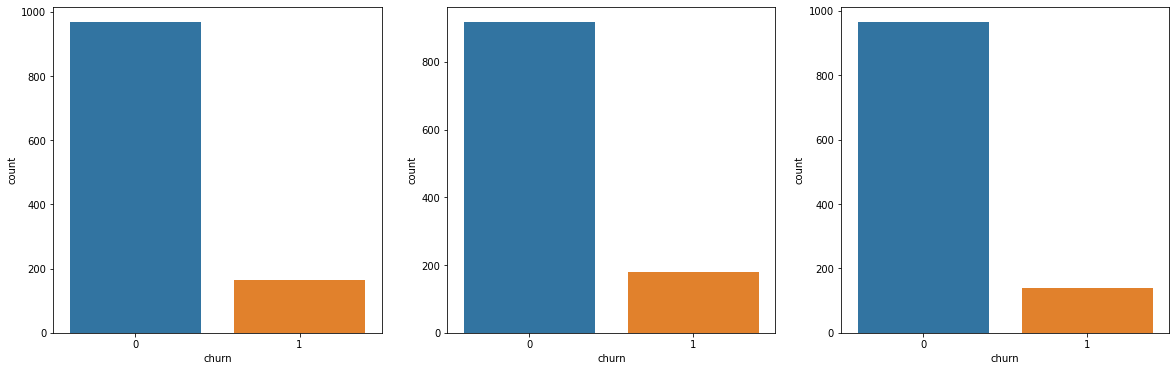

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.countplot(treat0_churn)
plt.subplot(1, 3, 2)
sns.countplot(treat1_churn)
plt.subplot(1, 3, 3)
sns.countplot(treat2_churn);

In [ ]:
treatment_churn = pd.crosstab(index=data.treatment, columns=data.churn)

In [138]:
t0_t1 = treatment_churn.iloc[[1, 0], :]
t2_t1 = treatment_churn.iloc[[1, 2], :]

In [140]:
t0_t1

churn,False.,True.
treatment,,
1,917,180
0,968,165


In [ ]:
def mcc(data):
    a = data[0, 0]
    b = data[0, 1]
    c = data[1, 0]
    d = data[1, 1]
    numerator = a * d - b * c
    denominator = np.sqrt((a + b) * (a + c) * (b + d) * (c + d))
    return numerator / denominator


In [141]:
print(f'Matthews correlation coefficient for treatment 0 and control: {mcc(t0_t1.values)}')
print(f'Matthews correlation coefficient for treatment 2 and control: {mcc(t2_t1.values)}')

Matthews correlation coefficient for treatment 0 and control: -0.0255102814980597
Matthews correlation coefficient for treatment 2 and control: -0.05541203496795406


Судя по коэффициенту корреляции Мэттьюса, наличие одного из видов treatment понижает отток клиентов. Проверим, насколько значим этот коэффициент с помощью статистики хи квадрат.

In [144]:
p01 = stats.chi2_contingency(t0_t1)[1]
p21 = stats.chi2_contingency(t2_t1)[1]
print(f'p-value for treatment 0 and control chi-squared: {p01}')
print(f'p-value for treatment 2 and control chi-squared: {p21}')

p-value for treatment 0 and control chi-squared: 0.2517524983193889
p-value for treatment 2 and control chi-squared: 0.011135281386020091


In [149]:
# Сделаем поправку Холма на множественную проверку гипотез.
from statsmodels.stats.tests.test_multi import multipletests
corrected_p = multipletests([p01, p21], alpha=0.05, method='holm')[1]
print(f'Corrected p-value for treatment 0 and control chi-squared: {corrected_p[0]}')
print(f'Corrected p-value for treatment 0 and control chi-squared: {corrected_p[1]}')

Corrected p-value for treatment 0 and control chi-squared: 0.2517524983193889
Corrected p-value for treatment 0 and control chi-squared: 0.022270562772040182


Отсюда видно, что критерий хи-квадрат с поправкой Йетса и поправкой Холма на множественную проверку гипотез позволяет отвергнуть нулевую гипотезу на уровне значимости 0.05 для treatment 2. То есть судя по этому критерию, можно советовать компании использовать treatment 2.

Проверим также Z-критерий для долей

In [150]:
from statsmodels.stats import proportion

In [162]:
c01 = t0_t1.values[:, 1]
n01 = t0_t1.values.sum(axis=1)
c21 = t2_t1.values[:, 1]
n21 = t2_t1.values.sum(axis=1)

In [163]:
zp01 = proportion.proportions_ztest(c01, n01, alternative='two-sided')[1]
zp21 = proportion.proportions_ztest(c21, n21, alternative='two-sided')[1]

In [164]:
print(f'p-value for treatment 0 and control Z-test: {zp01}')
print(f'p-value for treatment 2 and control Z-test: {zp21}')

p-value for treatment 0 and control Z-test: 0.2283311639045107
p-value for treatment 2 and control Z-test: 0.009348084294451078


In [165]:
# Сделаем поправку Холма на множественную проверку гипотез.
corrected_zp = multipletests([zp01, zp21], alpha=0.05, method='holm')[1]
print(f'Corrected p-value for treatment 0 and control chi-squared: {corrected_zp[0]}')
print(f'Corrected p-value for treatment 0 and control chi-squared: {corrected_zp[1]}')

Corrected p-value for treatment 0 and control chi-squared: 0.2283311639045107
Corrected p-value for treatment 0 and control chi-squared: 0.018696168588902155


Z-test для долей даёт такие же результаты. Treatment 2 действительно влияет на отток клиентов.

Проверим между собой treatment 0 и treatment 2

In [168]:
t0_t2 = treatment_churn.iloc[[0, 2], :]
t0_t2

churn,False.,True.
treatment,,
0,968,165
2,965,138


In [171]:
print(f'Matthews correlation coefficient for treatment 0 and treatment 2: {mcc(t0_t2.values)}')
print(f'p-value for treatment 0 and control chi-squared: {stats.chi2_contingency(t0_t2)[1]}')

Matthews correlation coefficient for treatment 0 and treatment 2: -0.029970570244258008
p-value for treatment 0 and control chi-squared: 0.17528809842137202


Видим, что отличие между treatment 0 и treatment 2 статистически не значимо при применении критерия хи-квадрат

In [172]:
c02 = t0_t2.values[:, 1]
n02 = t0_t2.values.sum(axis=1)
zp02 = proportion.proportions_ztest(c02, n02, alternative='two-sided')[1]
print(f'p-value for treatment 0 and treatment 2 Z-test: {zp02}')

p-value for treatment 0 and treatment 2 Z-test: 0.15642468860508016


Такой же результат показывает Z-тест для долей